# Simple Example for dynamically changing the ADC/DAC NCO used in digital mixing

In [1]:
# Setup the library
import pyrogue as pr
import os
top_level=f'{os.getcwd()}/..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import kek_bpm_rfsoc_dev
import numpy as np
import matplotlib.pyplot as plt
import time

# Create and start the root class
root = kek_bpm_rfsoc_dev.Root(
    ip          = '10.0.0.10', # RFSoC's IP address
    top_level   = top_level,
    pollEn      = False,
    zmqSrvEn    = False,
    rateDropEn  = False,
)

# Start the root device
root.start()

Rogue/pyrogue version v6.0.0. https://github.com/slaclab/rogue
2023-09-01T19:43:25.846 Using dynamically assigned TCP port 33151.
Root.Hardware.SpiBridge.Regs.ResetHw()
Loading path=/afs/slac.stanford.edu/u/re/ruckman/projects/kek-bpm-rfsoc-dev/software/notebooks/../config/defaults.yml Default Configuration File...
Root.RFSoC.Application.DacSigGenLoader.LoadRectFunction()
Root.RFSoC.AxiSocCore.AxiVersion count reset called


In [2]:
# Create useful pointers
AxiVersion = root.RFSoC.AxiSocCore.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = Root.RFSoC.AxiSocCore.AxiVersion
FwVersion    = 0x2000000
UpTime       = 3:21:13
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x4002000001602b051cb16245
FwTarget     = KekBpmRfSoc4x2
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv402 (Ubuntu 20.04.6 LTS)
BuildDate    = Fri 01 Sep 2023 04:03:42 PM PDT
Builder      = ruckman
###################################################


In [3]:
# Wait for DSP Clock to be stable after changing NCO value
def WaitDspClkStable():
    while(AxiVersion.DspReset.get()):
        time.sleep(0.01)

# Function for Setting DAC NCO only (units of MHz)
def SetDacNco(ncoFreqMhz,ch):
    # DAC is a "quad" tile, so only 1 NCO value to set in the RF Tile's RF block
    if ch==0:    
        root.RFSoC.RfDataConverter.dacTile[2].dacBlock[0].ncoFrequency.set(ncoFreqMhz)
    else:
        root.RFSoC.RfDataConverter.dacTile[0].dacBlock[0].ncoFrequency.set(ncoFreqMhz) 
    WaitDspClkStable()
    
# Function for Setting ADC NCO only (units of MHz)
def SetAdcNco(ncoFreqMhz,ch):
    # ADC is a "dual" tile, so only 2 NCO value (odd/even) to set in the RF Tile's RF block
    if ch==0:
        root.RFSoC.RfDataConverter.adcTile[2].adcBlock[2].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        root.RFSoC.RfDataConverter.adcTile[2].adcBlock[3].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Even
    elif ch==1:
        root.RFSoC.RfDataConverter.adcTile[2].adcBlock[0].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        root.RFSoC.RfDataConverter.adcTile[2].adcBlock[1].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Even
    elif ch==2:
        root.RFSoC.RfDataConverter.adcTile[0].adcBlock[2].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        root.RFSoC.RfDataConverter.adcTile[0].adcBlock[3].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Even
    else:
        root.RFSoC.RfDataConverter.adcTile[0].adcBlock[1].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        root.RFSoC.RfDataConverter.adcTile[0].adcBlock[0].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Even
    WaitDspClkStable()

# Function to trigger the waveform ring buffers
def TrigRingBuffer():
    root.Waveform.Updated.set(False)
    time.sleep(0.1)
    root.RFSoC.Application.SoftDacTrig()

    # Wait for Waveform
    while(root.Waveform.Updated.get() != True):
        time.sleep(0.01)

# Function to plot the ADC/DAC waveforms
def PlotWavform(type,ch):
    fig, axs = plt.subplots(3)
    if type=='Adc':
        axs[0].plot(root.Waveform.Time.value(),root.Waveform.AdcI[ch].value())
        axs[0].set_ylabel(f'ADC[{ch}].I') 
        axs[1].plot(root.Waveform.Time.value(),root.Waveform.AdcQ[ch].value())
        axs[1].set_ylabel(f'ADC[{ch}].Q') 
        axs[2].plot(root.Waveform.Time.value(),root.Waveform.AdcMag[ch].value())
        axs[2].set_ylabel(f'ADC[{ch}].Mag')  
    else:
        axs[0].plot(root.Waveform.Time.value(),root.Waveform.DacI[ch].value())
        axs[0].set_ylabel(f'DAC[{ch}].I')
        axs[1].plot(root.Waveform.Time.value(),root.Waveform.DacQ[ch].value())
        axs[1].set_ylabel(f'DAC[{ch}].Q') 
        axs[2].plot(root.Waveform.Time.value(),root.Waveform.DacMag[ch].value()) 
        axs[2].set_ylabel(f'DAC[{ch}].Mag') 
    axs[2].set_xlabel("Time (ns)")
    [axs[i].grid() for i in range(3)]
    
# Function to trigger then plot waveforms
def TriggerThenPlotWavform():  
    TrigRingBuffer()
    for i in range(4):
        PlotWavform(type='Adc',ch=i)
    for i in range(2):        
        PlotWavform(type='Dac',ch=i) 

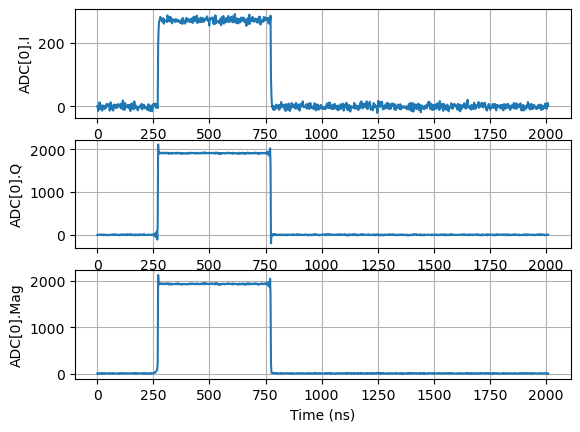

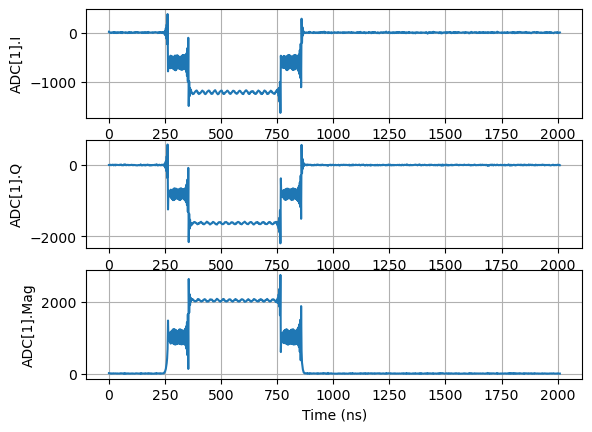

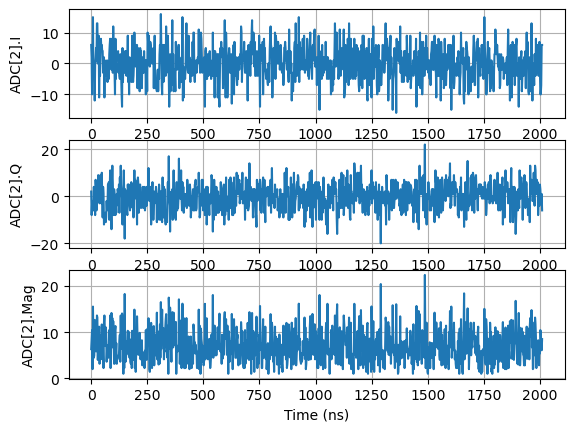

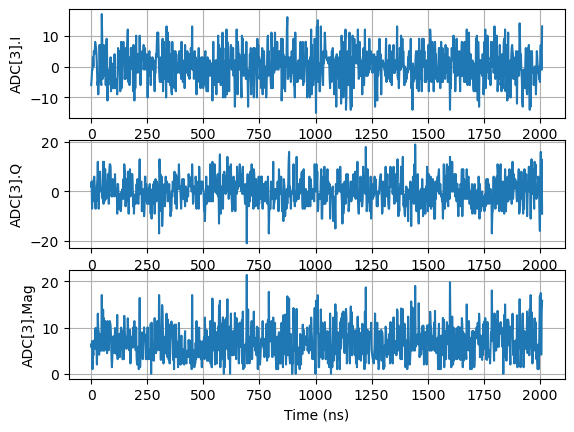

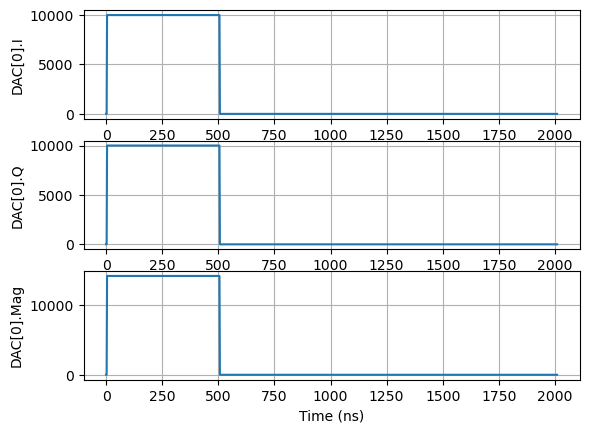

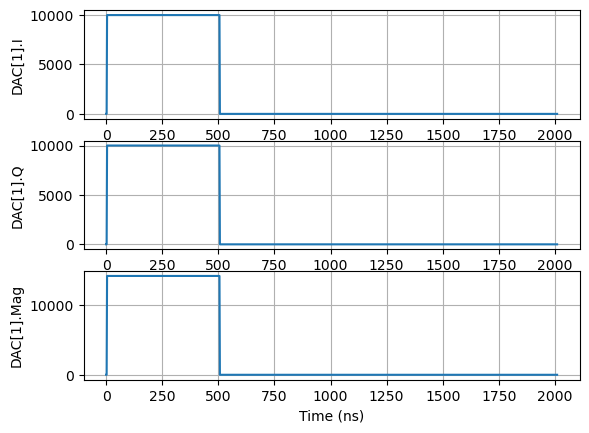

In [4]:
# Set both ADC and DAC to use a 1000 MHz NCO for digital RF mixing
SetAdcNco(ncoFreqMhz=1000.0,ch=0)
SetDacNco(ncoFreqMhz=1000.0,ch=0)

# Then trigger then plot waveforms
TriggerThenPlotWavform()

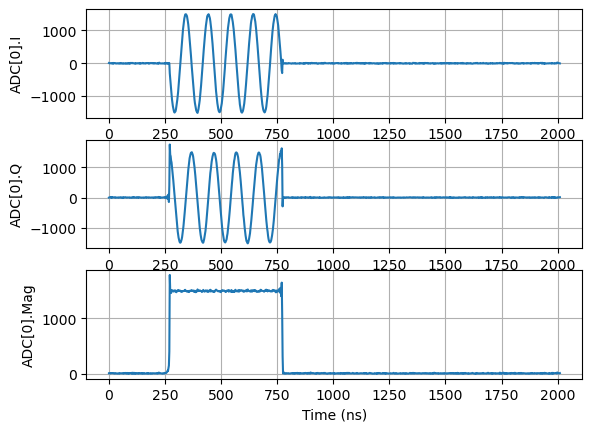

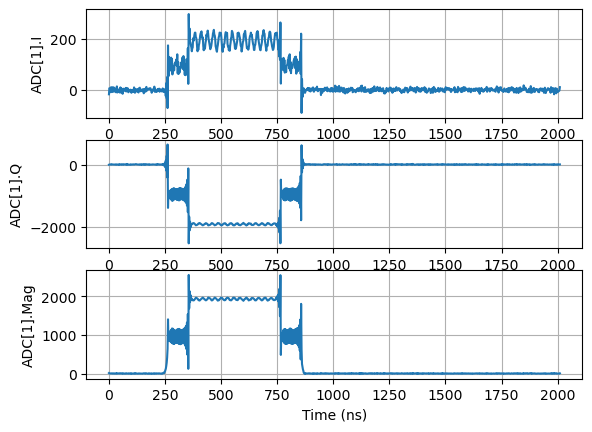

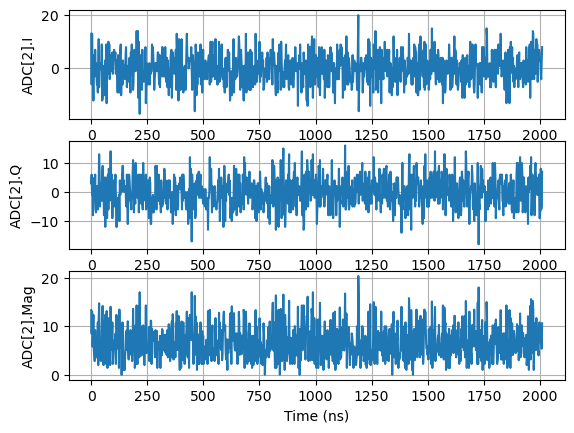

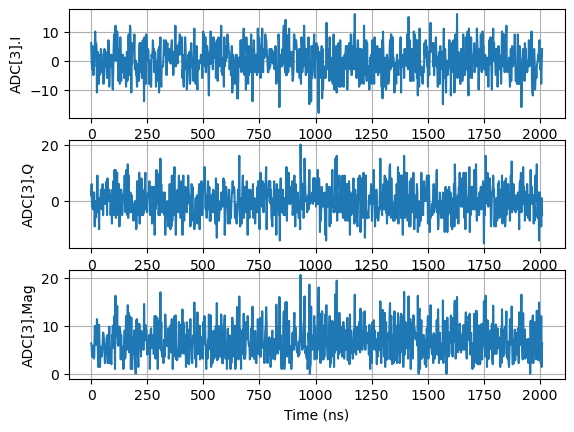

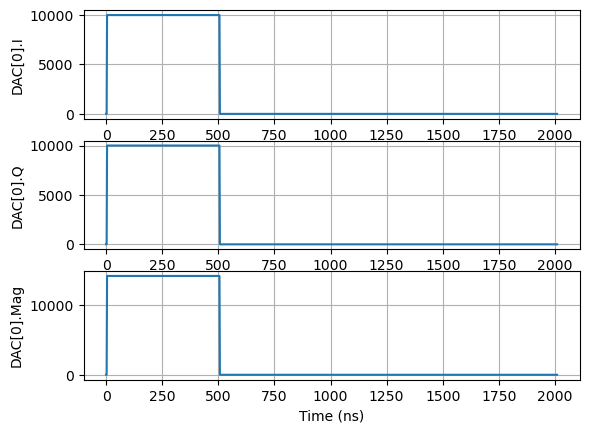

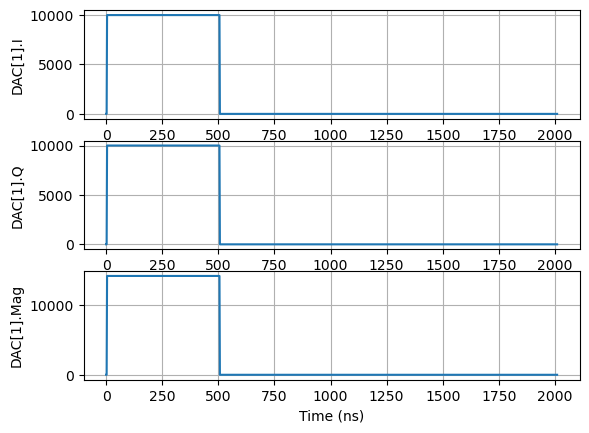

In [5]:
# Set ADC.NCO=1010 MHz & DAC.NCO=1000
SetAdcNco(ncoFreqMhz=1010.0,ch=0)
SetDacNco(ncoFreqMhz=1000.0,ch=0)

# Should observe 10 MHz signal on ADC waveform during the pulse
# 5 cycles over the ~500ns, 10 MHz = 1010MHz-1000MHz
TriggerThenPlotWavform()

In [6]:
# Stop the root device
root.stop()